In [1]:
import pickle
import numpy as np
from matplotlib import pyplot as plt 
import os 
from tqdm import tqdm
from pathlib import Path 
import json
import cv2
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression


D:\input\OpenLane\images\training\segment-12212767626682531382_2100_150_2120_150_with_camera_labels.avi D:\input\OpenLane\lane3d_1000\training\segment-12212767626682531382_2100_150_2120_150_with_camera_labels_cam_param.ini

D:\input\OpenLane\images\training\segment-17759280403078053118_6060_580_6080_580_with_camera_labels.avi D:\input\OpenLane\lane3d_1000\training\segment-17759280403078053118_6060_580_6080_580_with_camera_labels_cam_param.ini

In [2]:
# fpath_scene = r'D:\input\OpenLane\lane3d_1000\training\segment-12212767626682531382_2100_150_2120_150_with_camera_labels.pickle'
fpath_scene = r'D:\input\OpenLane\lane3d_1000\training\segment-17759280403078053118_6060_580_6080_580_with_camera_labels.pickle'

with open(fpath_scene, 'rb') as f:
    scene = pickle.load(f)

In [3]:
root_images_training = Path(r'D:\input\OpenLane\images\training')
root_images_validation = Path(r'D:\input\OpenLane\images\validation')
root_jsons_training = Path(r'D:\input\OpenLane\lane3d_1000\training')
root_jsons_validation = Path(r'D:\input\OpenLane\lane3d_1000\validation')

In [4]:
# read scene pickle files - around 10 secs for 1000 files
if True:
    fpaths_scene = list(Path(root_jsons_training).glob('*.pickle'))
    num_scene = len(fpaths_scene)
    is_oks = []

    for i, fpath_scene in tqdm(enumerate(fpaths_scene)):
        with open(fpath_scene, 'rb') as f:
            scene = pickle.load(f)
            is_oks.append(scene['at_least_1frame_valid'])
    is_oks = np.r_[is_oks]
np.sum(is_oks)

798it [00:08, 99.35it/s] 


500

In [5]:
# read scene pickle files - around 10 secs for 1000 files
if True:
    fpaths_scene = list(Path(root_jsons_training).glob('*.pickle'))
    num_scene = len(fpaths_scene)
    tXs, tYs, tZs = np.zeros(num_scene), np.zeros(num_scene), np.zeros(num_scene)
    pitches_deg, rolls_deg, yaws_deg = np.zeros(num_scene), np.zeros(num_scene), np.zeros(num_scene)

    for i, fpath_scene in tqdm(enumerate(fpaths_scene)):
        with open(fpath_scene, 'rb') as f:
            scene = pickle.load(f)
            tXs[i] = scene['cam_params']['CAM_TX']
            tYs[i] = scene['cam_params']['CAM_TY']
            tZs[i] = scene['cam_params']['CAM_TZ']
            pitches_deg[i] = scene['cam_params']['CAM_PITCH']
            rolls_deg[i] = scene['cam_params']['CAM_ROLL']
            yaws_deg[i] = scene['cam_params']['CAM_YAW']
            if scene['at_least_1frame_valid'] and np.abs(pitches_deg[i]) > 1.4:
                print(fpath_scene.stem, pitches_deg[i])



798it [00:01, 580.13it/s]


In [6]:
print(np.mean(tXs), np.mean(tYs), np.mean(tZs), np.mean(pitches_deg), np.mean(rolls_deg), np.mean(yaws_deg))
print(np.std(tXs), np.std(tYs), np.std(tZs), np.std(pitches_deg), np.std(rolls_deg), np.std(yaws_deg))

0.0 0.0 2.465622879946571 0.0 0.0 0.0
0.0 0.0 0.00030062526792563 0.0 0.0 0.0


In [24]:
fpaths_scene = list(Path(root_jsons_training).glob('*.pickle'))
num_scene = len(fpaths_scene)
X0s = np.zeros(num_scene)
Z0s = np.zeros(num_scene)
cnt = 0
for i, fpath_scene in tqdm(enumerate(fpaths_scene)):
    with open(fpath_scene, 'rb') as f:
        scene = pickle.load(f)
        for i_frame in range(len(scene['frames'])):
            frame = scene['frames'][i_frame]
            if frame['flag_egolane_valid']:
                maxlen_l = np.min((10, frame['left']['XYZs'].shape[1]))
                maxlen_r = np.min((10, frame['right']['XYZs'].shape[1]))
                X0s[cnt] = (np.mean(frame['left']['XYZs'][0,:maxlen_l]) + np.mean(frame['right']['XYZs'][0,:maxlen_l])) / 2
                Z0s[cnt] = (np.mean(frame['left']['XYZs'][2,:maxlen_l]) + np.mean(frame['right']['XYZs'][2,:maxlen_l])) / 2
                
                if np.abs(Z0s[cnt]) > 3.0:
                    print(fpath_scene.stem, np.abs(Z0s[cnt]))
                cnt += 1
                break
cnt

104it [00:00, 507.47it/s]

segment-10391312872392849784_4099_400_4119_400_with_camera_labels 3.170641452812707
segment-1172406780360799916_1660_000_1680_000_with_camera_labels 3.053474138182055


206it [00:00, 472.60it/s]

segment-13585809231635721258_1910_770_1930_770_with_camera_labels 3.0397341988491173
segment-13909033332341079321_4007_930_4027_930_with_camera_labels 3.0207510493979925
segment-14466332043440571514_6530_560_6550_560_with_camera_labels 3.0222742084568344


317it [00:00, 485.49it/s]

segment-15832924468527961_1564_160_1584_160_with_camera_labels 3.155565502777973
segment-17601040886987343289_472_000_492_000_with_camera_labels 3.1968944216363173


605it [00:01, 544.94it/s]

segment-3617043125954612277_240_000_260_000_with_camera_labels 3.389181062373733
segment-3894883757914505116_1840_000_1860_000_with_camera_labels 3.6900705372977995
segment-4266984864799709257_720_000_740_000_with_camera_labels 4.673259985146597


798it [00:01, 532.36it/s]

segment-7517545172000568481_2325_000_2345_000_with_camera_labels 3.0336455895196135


599

Text(0.5, 1.0, 'pitch_deg\nmean:-0.049, std:0.595')

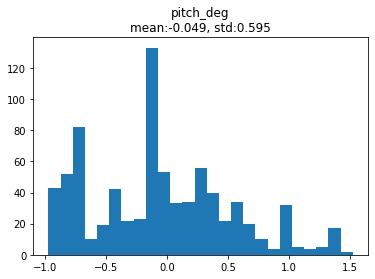

In [38]:
bins = np.arange(np.min(pitches_deg), np.max(pitches_deg), 0.1)
plt.hist(pitches_deg, bins)
plt.title(f'pitch_deg\nmean:{np.mean(pitches_deg):.3f}, std:{np.std(pitches_deg):.3f}')

(3.0211206628417755, 13.641851088853045)

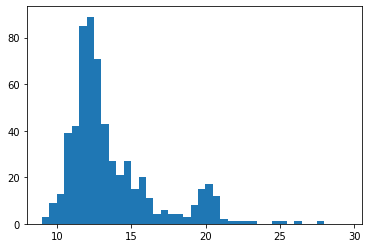

In [26]:
X0s_ = np.abs(X0s[:cnt])
bins = np.arange(np.min(X0s_), np.max(X0s_), 0.5)
plt.hist(X0s_, bins)
np.std(X0s_), np.mean(X0s_)

(0.23809202768609064, -2.4293204278061324)

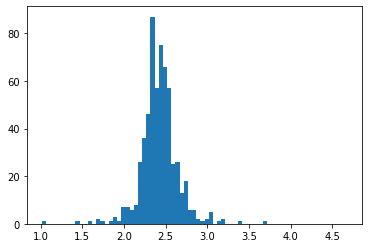

In [15]:
Z0s_ = np.abs(Z0s[:cnt])
bins = np.arange(np.min(Z0s_), np.max(Z0s_), 0.05)
plt.hist(Z0s_, bins)
np.std(Z0s[:cnt]), np.mean(Z0s[:cnt])

In [27]:
pitch = np.std(pitches_deg) * np.pi / 180.0
13 * np.tan(pitch)

0.13500027067506287

In [159]:
fpath_scene.stem

'segment-9985243312780923024_3049_720_3069_720_with_camera_labels'

In [94]:
640 / 256

2.5

In [95]:
1920 / (1280 * (1-0.2888888))

2.1093747363281583

In [96]:
np.mean(np.hstack((frame['left']['XYZs'][2,:10], frame['right']['XYZs'][2,:10])))

-2.504316380435758

In [32]:
fx = scene['cam_params']['CAM_FX']
fy = scene['cam_params']['CAM_FY']
cx = scene['cam_params']['CAM_CX']
cy = scene['cam_params']['CAM_CY']
def XYZ2xy(Xs, Ys, Zs, K=None, Z_offset=0, flag_bundle=False):
    if K is None:
        K = np.r_[[[fx, 0, cx],
                [0, fy, cy],
                [0, 0, 1]]]
    YZXs = np.r_[[-Ys], 
                [Z_offset-Zs], 
                [Xs]]
    xys = K @ YZXs
    xys /= xys[2]
    if flag_bundle:
        return xys
    else:
        return xys[0], xys[1]

In [33]:
scene['name']

'segment-17759280403078053118_6060_580_6080_580_with_camera_labels'

In [22]:
import io

# define a function which returns an image as numpy array from figure
def get_img_from_fig(fig, dpi=120):
    buf = io.BytesIO()
    fig.savefig(buf, format="png", dpi=dpi)
    buf.seek(0)
    img_arr = np.frombuffer(buf.getvalue(), dtype=np.uint8)
    buf.close()
    img = cv2.imdecode(img_arr, 1)
    # img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    return img

In [24]:
pixel_pitch_change_rate

0.08470084436105751

In [48]:
# fpath_scene = r'D:\input\OpenLane\lane3d_1000\training\segment-12212767626682531382_2100_150_2120_150_with_camera_labels.pickle'
fpath_scene = r'D:\input\OpenLane\lane3d_1000\training\segment-17759280403078053118_6060_580_6080_580_with_camera_labels.pickle'
with open(fpath_scene, 'rb') as f:
    scene = pickle.load(f)

# fpath_rsp = r'D:\input\OpenLane\lane3d_1000\training\segment-12212767626682531382_2100_150_2120_150_with_camera_labels_rsp.json'
fpath_rsp = r'D:\input\OpenLane\lane3d_1000\training\segment-17759280403078053118_6060_580_6080_580_with_camera_labels_rsp.json'
with open(fpath_rsp) as f:
    rsp = json.load(f)

  2%|▏         | 4/198 [00:00<00:43,  4.42it/s]


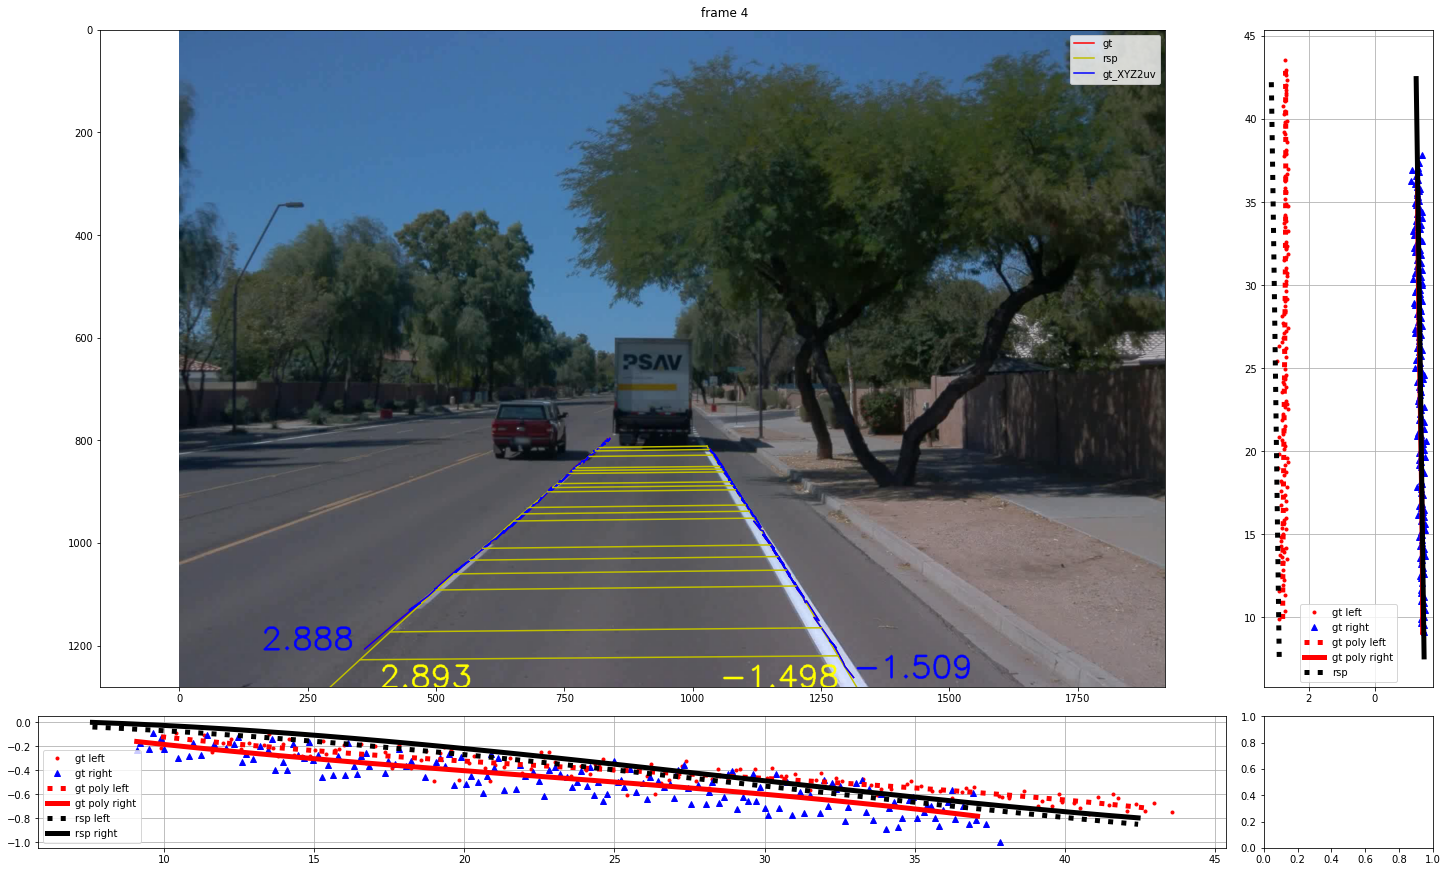

In [52]:
%matplotlib inline

# dir_jpgs = r'D:\input\OpenLane\images\training\segment-12212767626682531382_2100_150_2120_150_with_camera_labels'
# dir_jpgs = r'D:\input\OpenLane\images\training\segment-17759280403078053118_6060_580_6080_580_with_camera_labels'
# fpaths_img = list(Path(dir_jpgs).glob('*.jpg'))
fpath_video = r'D:\input\OpenLane\images\training\segment-17759280403078053118_6060_580_6080_580_with_camera_labels.avi'
vc = cv2.VideoCapture(fpath_video)
fpath_video_out = r'D:\input\OpenLane\images\training\segment-17759280403078053118_6060_580_6080_580_with_camera_labels_compare_trash.avi'
fourcc = cv2.VideoWriter_fourcc(*'DIVX')
fps = 30.0
w_fig, h_fig = 20,12
dpi = 120
vw = cv2.VideoWriter(fpath_video_out, fourcc, fps, (w_fig*dpi, h_fig*dpi))

fig = plt.figure(constrained_layout=True, figsize=(w_fig, h_fig))
axs = fig.subplot_mosaic([[0,1],
                          [2,3]],
                        gridspec_kw={'width_ratios':[7,1],
                                    'height_ratios':[5,1]})

poly = PolynomialFeatures(degree=3, include_bias=True)

Xs_null_poly = poly.fit_transform(np.arange(4).reshape(-1,1))
Ys_null = np.arange(4)
gtY_l = LinearRegression().fit(Xs_null_poly, Ys_null)
gtZ_l = LinearRegression().fit(Xs_null_poly, Ys_null)
gtY_r = LinearRegression().fit(Xs_null_poly, Ys_null)
gtZ_r = LinearRegression().fit(Xs_null_poly, Ys_null)
rspY_l = LinearRegression().fit(Xs_null_poly, Ys_null)
rspZ_l = LinearRegression().fit(Xs_null_poly, Ys_null)
rspY_r = LinearRegression().fit(Xs_null_poly, Ys_null)
rspZ_r = LinearRegression().fit(Xs_null_poly, Ys_null)

# scene['cam_params']['CAM_YAW'] = 0
# scene['cam_params']['CAM_PITCH'] = 0
# scene['cam_params']['CAM_ROLL'] = 0
pitch_deg = scene['cam_params']['CAM_PITCH']
img_h = scene['cam_params']['PIXEL_HEIGHT']
cy = scene['cam_params']['CAM_CY']
tZ = scene['cam_params']['CAM_TZ']
pixel_width_1m_ref = 1/tZ*(img_h - cy)
pixel_width_1m = 1/tZ*(fy*np.tan(1.0 * np.pi / 180.0) + img_h - cy)
pixel_pitch_change_rate = np.abs(1 - pixel_width_1m / pixel_width_1m_ref)

rsp_pitch_ratio = 1 + pixel_pitch_change_rate * pitch_deg     # refer to oc_test_calc.xlsx
# rsp_pitch_ratio = 1

for idx in tqdm(range(0, len(scene['frames']))):
    if idx >= len(rsp):
        break

    frame = scene['frames'][idx]
    R = scene['R']
    frame_rsp = rsp[idx]
    font=cv2.FONT_HERSHEY_SIMPLEX
    if frame['flag_egolane_valid'] and frame_rsp['valid']:
        retval, img = vc.read()
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        h_img, w_img = img.shape[0], img.shape[1]

        uvs_gt_l = frame['left']['uvs']
        uvs_gt_r = frame['right']['uvs']
        XYZs_gt_l = frame['left']['XYZs']
        XYZs_gt_r = frame['right']['XYZs']
        uvs_rsp_l = frame_rsp['left']['uvs']
        uvs_rsp_r = frame_rsp['right']['uvs']

        ax = axs[0]
        ax.plot(uvs_gt_l[0], uvs_gt_l[1], 'r', label='gt')
        ax.plot(uvs_gt_r[0], uvs_gt_r[1], 'r')
        ax.plot(uvs_rsp_l[0], uvs_rsp_l[1], 'y', label='rsp')
        ax.plot(uvs_rsp_r[0], uvs_rsp_r[1], 'y')

        XYZ2uvs_l = XYZ2xy(XYZs_gt_l[0], XYZs_gt_l[1], XYZs_gt_l[2], flag_bundle=True)
        XYZ2uvs_r = XYZ2xy(XYZs_gt_r[0], XYZs_gt_r[1], XYZs_gt_r[2], flag_bundle=True)
        ax.plot(XYZ2uvs_l[0], XYZ2uvs_l[1], 'b', label='gt_XYZ2uv')
        ax.plot(XYZ2uvs_r[0], XYZ2uvs_r[1], 'b')


        pl_gt = np.r_[uvs_gt_l[0][0]-200, uvs_gt_l[1][0]].astype(int)
        pr_gt = np.r_[uvs_gt_r[0][0], uvs_gt_r[1][0]].astype(int)
        pl_rsp = np.r_[uvs_gt_l[0][0]+30, h_img].astype(int)
        pr_rsp = np.r_[uvs_gt_r[0][0]-260, h_img].astype(int)
        cv2.putText(img, f'{XYZs_gt_l[1,0]:.3f}', pl_gt, font, 2, (0,0,255), 3)
        cv2.putText(img, f'{XYZs_gt_r[1,0]:.3f}', pr_gt, font, 2, (0,0,255), 3)

        X_bottom = 7
        Xs_rsp = np.arange(X_bottom, frame_rsp['Xf'])   # rsp 계산은 이걸로 하고,
        Xs_rsp_pitch_comp = rsp_pitch_ratio * Xs_rsp    # 나중에 그림 그릴때는 pitch_ratio 보정된 Xs로
        Xs_rsp_poly = poly.fit_transform(Xs_rsp.reshape(-1,1))

        gtY_l.coef_[:] = frame['left']['coeff_Y'][:]
        gtZ_l.coef_[:] = frame['left']['coeff_Z'][:]
        gtZ_l.coef_[0] += tZ
        gtY_r.coef_[:] = frame['right']['coeff_Y'][:]
        gtZ_r.coef_[:] = frame['right']['coeff_Z'][:]
        gtZ_r.coef_[0] += tZ
        Xs_l_gt = np.arange(frame['left']['X0'], frame['left']['Xf'])
        Xs_r_gt = np.arange(frame['right']['X0'], frame['right']['Xf'])
        Xs_l_gt_poly = poly.fit_transform(Xs_l_gt.reshape(-1,1))
        Xs_r_gt_poly = poly.fit_transform(Xs_r_gt.reshape(-1,1))
        Ys_l_gt = gtY_l.predict(Xs_l_gt_poly)
        Ys_r_gt = gtY_r.predict(Xs_r_gt_poly)
        Zs_l_gt = gtZ_l.predict(Xs_l_gt_poly)
        Zs_r_gt = gtZ_r.predict(Xs_r_gt_poly)

        Ys_gt_lr = np.r_[[gtY_l.predict(Xs_rsp_poly)],
                        [gtY_r.predict(Xs_rsp_poly)]]

        rspY_l.coef_[:] = np.r_[frame_rsp['left']['coeff_Y'][:]]
        rspZ_l.coef_[:] = np.r_[frame_rsp['left']['coeff_Z'][:]]
        rspY_r.coef_[:] = np.r_[frame_rsp['right']['coeff_Y'][:]]
        rspZ_r.coef_[:] = np.r_[frame_rsp['right']['coeff_Z'][:]]
        Y_l_rsp = rsp_pitch_ratio * rspY_l.predict(Xs_rsp_poly)
        Y_r_rsp = rsp_pitch_ratio * rspY_r.predict(Xs_rsp_poly)
        Z_l_rsp = rsp_pitch_ratio * rspZ_l.predict(Xs_rsp_poly)
        Z_r_rsp = rsp_pitch_ratio * rspZ_r.predict(Xs_rsp_poly)
        cv2.putText(img, f'{Y_l_rsp[0]:.3f}', pl_rsp, font, 2, (255,255,0), 3)
        cv2.putText(img, f'{Y_r_rsp[0]:.3f}', pr_rsp, font, 2, (255,255,0), 3)
        ax.imshow(img)

        for u_l, v_l, u_r, v_r in list(zip(uvs_rsp_l[0], uvs_rsp_l[1], uvs_rsp_r[0], uvs_rsp_r[1])):
            ax.plot([u_l, u_r], [v_l, v_r], 'y')
        ax.set_ylim(img.shape[0], 0)
        ax.legend()

        ax = axs[1]
        ax.plot(XYZs_gt_l[1], XYZs_gt_l[0], 'r.', label='gt left')
        ax.plot(XYZs_gt_r[1], XYZs_gt_r[0], 'b^', label='gt right')
        ax.plot(Ys_l_gt, Xs_l_gt, 'r:', linewidth=5, label='gt poly left')
        ax.plot(Ys_r_gt, Xs_r_gt, 'r-', linewidth=5, label='gt poly right')
        ax.plot(Y_l_rsp, Xs_rsp_pitch_comp, 'k:', linewidth=5, label='rsp')
        ax.plot(Y_r_rsp, Xs_rsp_pitch_comp, 'k-', linewidth=5)
        ax.invert_xaxis()
        ax.legend()
        ax.grid()

        ax = axs[2]
        ax.plot(XYZs_gt_l[0], XYZs_gt_l[2] + tZ, 'r.', label='gt left')
        ax.plot(XYZs_gt_r[0], XYZs_gt_r[2] + tZ, 'b^', label='gt right')
        ax.plot(Xs_l_gt, Zs_l_gt, 'r:', linewidth=5, label='gt poly left')
        ax.plot(Xs_r_gt, Zs_r_gt, 'r-', linewidth=5, label='gt poly right')
        ax.plot(Xs_rsp_pitch_comp, Z_l_rsp, 'k:',  linewidth=5,label='rsp left')
        ax.plot(Xs_rsp_pitch_comp, Z_r_rsp, 'k-', linewidth=5, label='rsp right')
        ax.legend()
        ax.grid()

        plt.suptitle(f'frame {idx}')
        # plt.pause(0.1)
        # dir_output = Path('output') / scene['name']
        # if not os.path.isdir(dir_output):
        #     os.makedirs(dir_output)
        # plt.savefig(dir_output / (str(idx) + '.png'))

        img_fig = get_img_from_fig(fig)
        vw.write(img_fig)
        
        break
        axs[0].cla()
        axs[1].cla()
        axs[2].cla()

cv2.destroyAllWindows()
vw.release()


In [50]:
XYZs_gt_l[0]

array([ 9.90254703, 10.39962982, 11.32884246, 11.59179664, 11.95172943,
       12.2216344 , 12.54833959, 12.83789036, 13.32479375, 13.51167627,
       13.6386716 , 13.77998025, 13.95952109, 14.1687002 , 14.31368943,
       14.59248464, 14.84543825, 15.0415036 , 15.30399145, 15.40406237,
       15.69824186, 15.83507353, 15.9858145 , 16.55062691, 16.73425329,
       17.02877296, 17.36718714, 17.59474561, 17.82941683, 18.10647361,
       18.21919454, 18.563454  , 18.73152368, 18.97471096, 19.18896444,
       19.32261573, 19.57080664, 19.80875441, 20.14257906, 20.33496051,
       20.69646484, 20.84594779, 21.03171461, 21.32009891, 21.52978471,
       21.90624057, 22.22585124, 22.53803069, 22.6603283 , 22.82861546,
       23.03400999, 23.56738164, 23.87950587, 24.04778327, 24.1916257 ,
       24.34033152, 24.48954016, 24.60906022, 24.95699613, 25.43148502,
       25.67561244, 26.08247112, 26.23364941, 26.35701801, 26.55096   ,
       26.80345467, 27.11915813, 27.24072208, 27.39182593, 27.73

In [138]:
Xs_l_gt, Xs_r_gt

(array([ 9.95703105, 10.95703105, 11.95703105, 12.95703105, 13.95703105,
        14.95703105, 15.95703105, 16.95703105, 17.95703105, 18.95703105,
        19.95703105, 20.95703105, 21.95703105, 22.95703105, 23.95703105,
        24.95703105, 25.95703105, 26.95703105, 27.95703105, 28.95703105,
        29.95703105, 30.95703105, 31.95703105, 32.95703105, 33.95703105]),
 array([ 9.18456405, 10.18456405, 11.18456405, 12.18456405, 13.18456405,
        14.18456405, 15.18456405, 16.18456405, 17.18456405, 18.18456405,
        19.18456405, 20.18456405, 21.18456405, 22.18456405, 23.18456405,
        24.18456405, 25.18456405, 26.18456405, 27.18456405, 28.18456405]))

In [110]:
rspY_l.coef_

array([ 0.00000000e+00,  1.00000000e+00,  2.05526459e-15, -3.86909160e-16])

In [56]:
frame['name']

'150863259715467700'

In [173]:
1.795 + 1.791, 1.996 + 1.57

(3.586, 3.566)

In [35]:
aa = [1,2,3,{1:5, 6:3},5,6]
for a in aa:
    if a == {1:5, 6:3}:
        aa.remove(a)
aa

[1, 2, 3, 5, 6]

In [120]:
tX = scene['cam_params']['CAM_TX']
tY = scene['cam_params']['CAM_TY']
tZ = scene['cam_params']['CAM_TZ']
tX, tY, tZ

(1.5441294660333627, -0.022635664254479763, 2.1153963267842166)

In [119]:
X_bottom = 8
Xs_rsp = np.arange(X_bottom, frame_rsp['Xf'])

poly = PolynomialFeatures(degree=3, include_bias=True)
Xs_rsp_poly = poly.fit_transform(Xs_rsp.reshape(-1,1))

Xs_null_poly = poly.fit_transform(np.arange(4).reshape(-1,1))
Ys_null = np.arange(4)
gtY_l = LinearRegression().fit(Xs_null_poly, Ys_null)
gtZ_l = LinearRegression().fit(Xs_null_poly, Ys_null)
gtY_r = LinearRegression().fit(Xs_null_poly, Ys_null)
gtZ_r = LinearRegression().fit(Xs_null_poly, Ys_null)
gtY_l.coef_[:] = frame['left']['coeff_Y'][:]
gtZ_l.coef_[:] = frame['left']['coeff_Z'][:]
gtY_r.coef_[:] = frame['right']['coeff_Y'][:]
gtZ_r.coef_[:] = frame['right']['coeff_Z'][:]

Ys_gt_lr = np.r_[[gtY_l.predict(Xs_rsp_poly)],
                 [gtY_r.predict(Xs_rsp_poly)]]
Ys_gt_lr[:,:3]         


array([[ 1.99615148,  1.98069239,  1.96783202],
       [-1.57045428, -1.58258839, -1.59201435]])

In [52]:
Xs_rsp = [5., 6., 7., 8., 9., 10.,
            12., 13., 14., 15.,
            18., 19., 20.,
            23., 24., 25.,
            28., 29., 30.,
            35., 38., 40.,
            45., 48., 50.,
            60., 70., 80., 90., 100., 120., 150., 200.,]
len(Xs_rsp)

33

In [118]:
Xs_rsp = np.arange(8, frame_rsp['Xf'])

poly = PolynomialFeatures(degree=3, include_bias=True)
Xs_rsp_poly = poly.fit_transform(Xs_rsp.reshape(-1,1))

Xs_null_poly = poly.fit_transform(np.arange(4).reshape(-1,1))
Ys_null = np.arange(4)
rspY_l = LinearRegression().fit(Xs_null_poly, Ys_null)
rspZ_l = LinearRegression().fit(Xs_null_poly, Ys_null)
rspY_r = LinearRegression().fit(Xs_null_poly, Ys_null)
rspZ_r = LinearRegression().fit(Xs_null_poly, Ys_null)
rspY_l.coef_[:] = frame_rsp['left']['coeff_Y'][:]
rspZ_l.coef_[:] = frame_rsp['left']['coeff_Z'][:]
rspY_r.coef_[:] = frame_rsp['right']['coeff_Y'][:]
rspZ_r.coef_[:] = frame_rsp['right']['coeff_Z'][:]

Ys_rsp_lr = np.r_[[rspY_l.predict(Xs_rsp_poly)],
                  [rspY_r.predict(Xs_rsp_poly)]]
Ys_rsp_lr[:,:3]

array([[ 1.50526721,  1.53319115,  1.56137641],
       [-1.45113853, -1.42329133, -1.39517456]])

In [87]:
Ys_rsp_lr = np.r_[[rspY_l.predict(Xs_rsp_poly)],
                  [rspY_r.predict(Xs_rsp_poly)]]
Ys_rsp_lr[:,:3]

array([[ 1.50526721,  1.53319115,  1.56137641],
       [-1.45113853, -1.42329133, -1.39517456]])

In [241]:
extrinsic = np.r_[
[
        [
            0.9999701273142104,
            -0.0016368385777447104,
            -0.007554153736338644,
            1.5441294660333627
        ],
        [
            0.0016649680658269266,
            0.9999916987008372,
            0.003718926021575489,
            -0.022635664254479763
        ],
        [
            0.007548003745468662,
            -0.0037313923520023227,
            0.9999645515469905,
            2.1153963267842166
        ],
        [
            0.0,
            0.0,
            0.0,
            1.0
        ]
    ]]
R = extrinsic[:3,:3]
roll_deg = np.arctan2(R[2,1], R[2,2]) * 180.0 / np.pi
pitch_deg = -np.arctan2(-R[2,0], np.sqrt(R[2,1]**2 + R[2,2]**2)) * 180.0 / np.pi
yaw_deg = np.arctan2(R[1,0], R[0,0]) * 180.0 / np.pi
roll_deg, pitch_deg, yaw_deg

(-0.213799620046796, 0.4324728649305793, 0.09539840484804793)

In [242]:
3 * 2.4/2.1

3.428571428571428